# Analyze DOPE-v1.1 (3k) with ResPose-v1.1 (3k)
## Pretrained VGG
## Corrected map-slicing

In this notebook I try to compare the performance of both DOPE and ResPosev1. Both data were trainined on 010_potted_meat_can_16k = 3k images for 60 epochs.

In this notebook I try to compare the performance of both DOPE and ResPosev1. Both data were trainined on 010_potted_meat_can_16k = 3k images for 60 epochs.
Previously my map-slicing from ResPose's output was wrong. Now it is corrected.
The results indicate that ResPose is working now and working very well despite having 1/3 less numb. of filters compared to DOPE.

Compared to not using VGG pretrained weights this model is more confident in its predictions.

In [1]:
import cv2
import matplotlib.pyplot as plt
import torch
from detector import *
from dope_utilities import *

## Load Data and Models

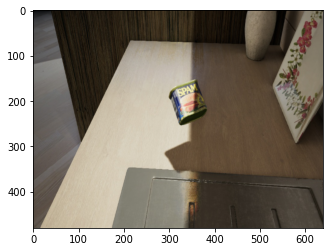

In [2]:
## Select epoch number of DOPE and ResPose to comapre
dope_epoch = 45
rp_epoch = 45


# load color image
data_path = 'Dataset/dev/'
index = 0
in_img, beliefsTruths, _ = get_truth_maps(data_path, index)

width,height = 480,640
# in_img = cv2.imread(img_path)
in_img = cv2.resize(in_img, (height, width))
# in_img = cv2.cvtColor(in_img, cv2.COLOR_BGR2RGB)
plt.imshow(in_img)

In [3]:
# Misc
name = 'meat' # Not useful
gpu_id = 0 # which gpu to use

## DOPE - Select weight
network="DOPE"
net_path = 'weights/dope_meat_v1.1/net_epoch_' + str(dope_epoch) + '.pth'
model = ModelData(name, net_path, gpu_id, network)
model.load_net_model()
dope_model = model.net

# ResPose - Select weight
network="ResPose"
net_path = "weights/rp_meat_v1.1/net_epoch_" + str(rp_epoch) + '.pth'
model = ModelData(name, net_path, gpu_id, network)
model.load_net_model()
rp_model = model.net

Loading DOPE model 'weights/dope_meat_v1.1/net_epoch_45.pth'...
Training network without imagenet weights.
    Model loaded in 4.864654779434204 seconds.
Loading DOPE model 'weights/rp_meat_v1.1/net_epoch_45.pth'...
Training network without imagenet weights.
    Model loaded in 4.446999549865723 seconds.


## Belief Maps Comparison
Belief Maps (6th cascade's output) from both the netowrks are compared side by side. The maps are overlaid on top of the original input image. Belief maps are thresholded to display the top 90% predicted locations.

DOPE Epoch: 45
ResPose Epoch: 45


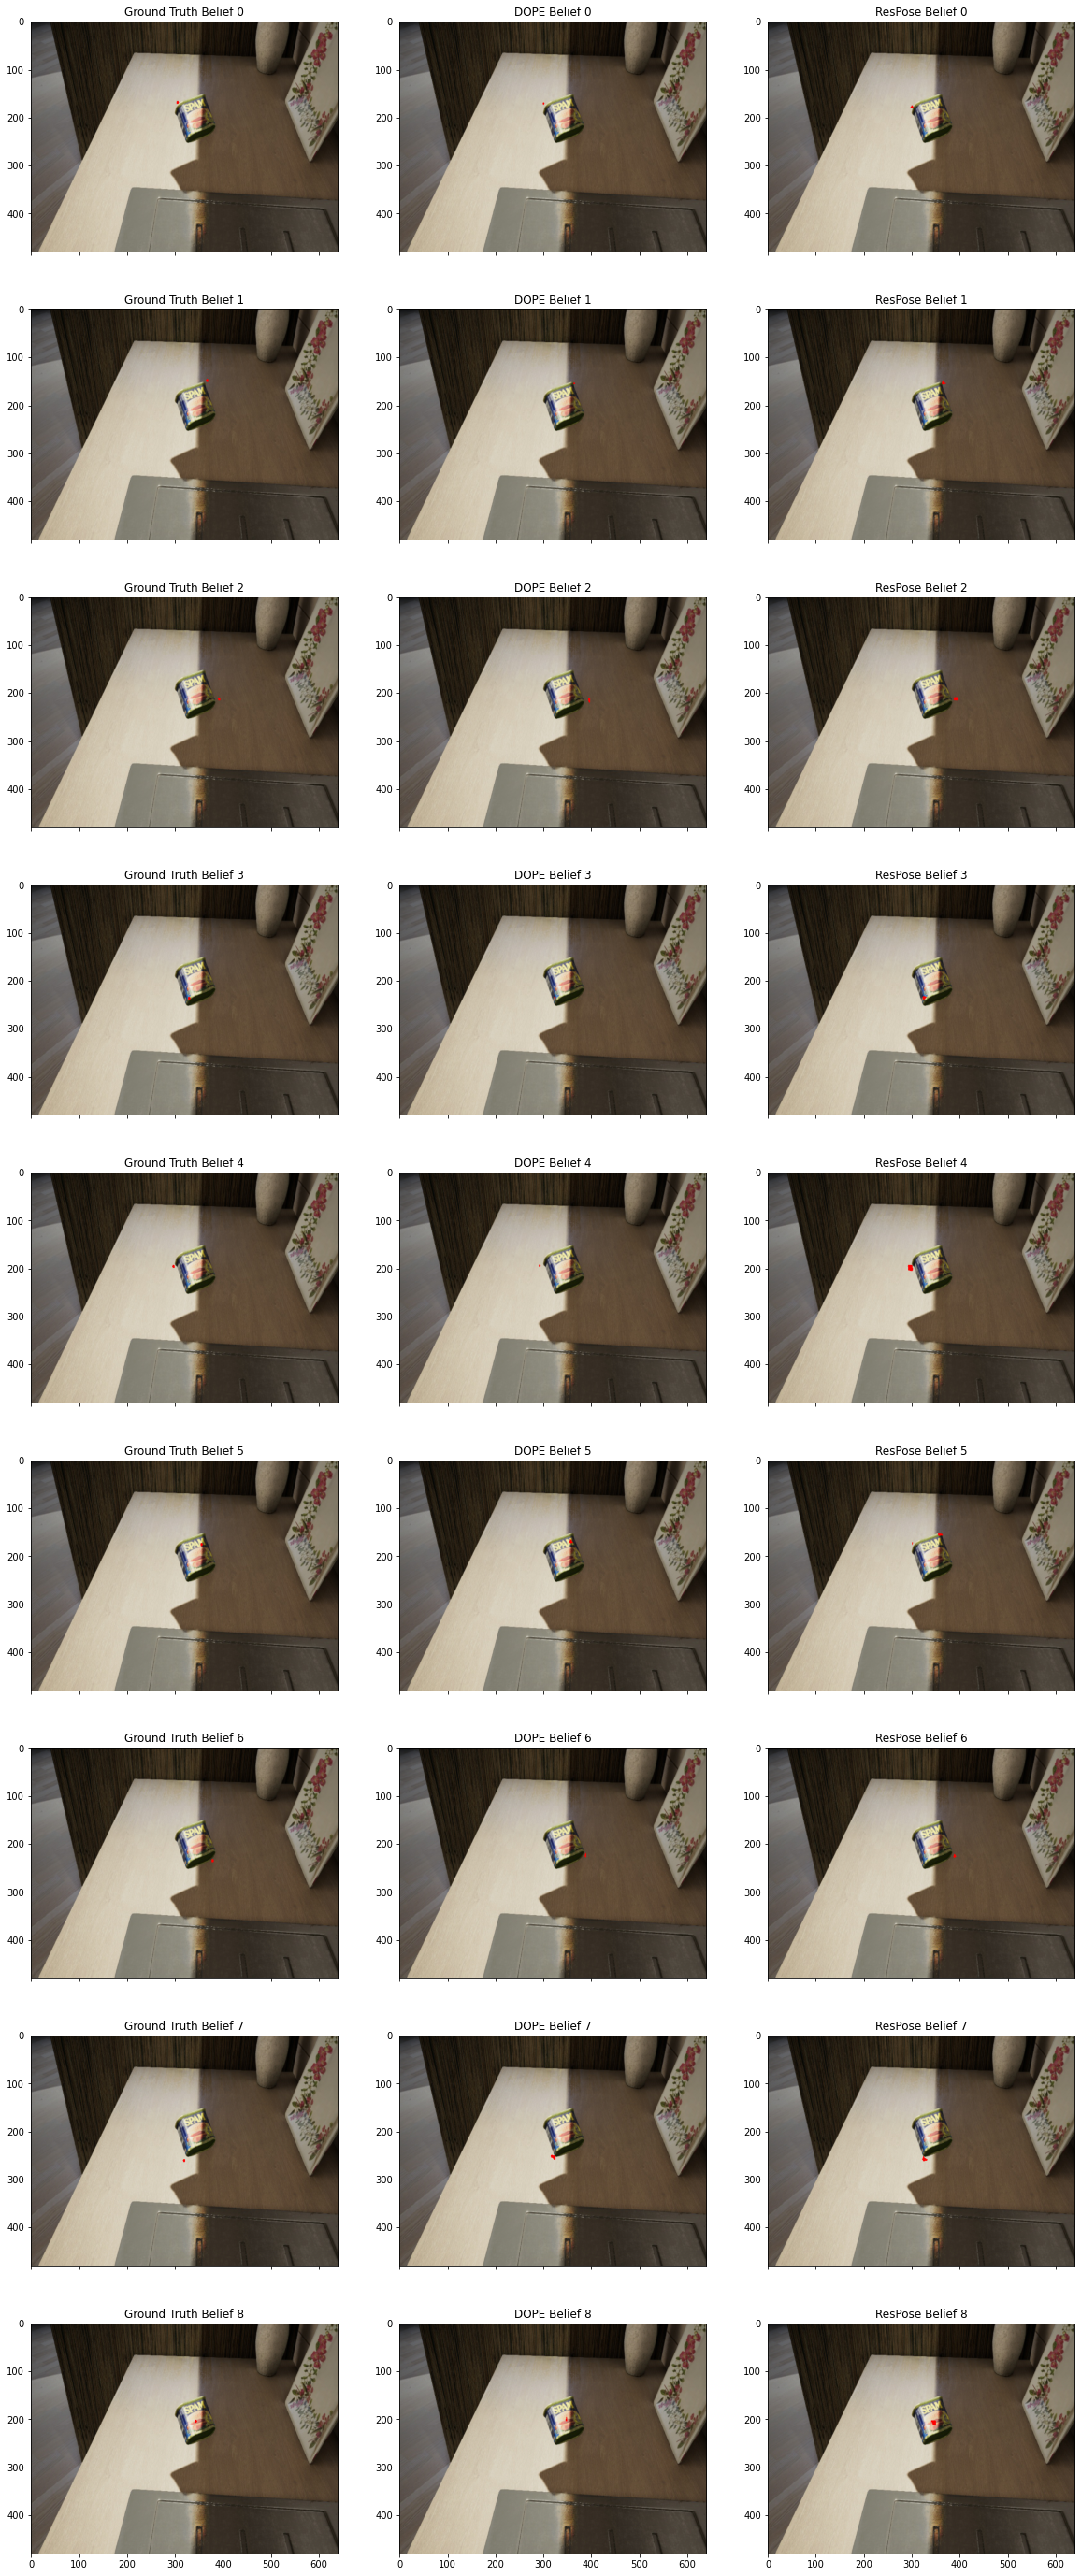

In [4]:
# Run network inference
image_tensor = transform(in_img)
image_torch = Variable(image_tensor).cuda().unsqueeze(0)

out, seg = dope_model(image_torch)
beliefs_dope = out[-1][0].cpu() # Select the last cascade's output only

out, seg = reshape_maps(rp_model(image_torch))
beliefs_rp = out[-1][0].cpu() # Select the last cascade's output only


compare_belief_maps(beliefsTruths, beliefs_dope, beliefs_rp, in_img)
print(f"DOPE Epoch: {dope_epoch}")
print(f"ResPose Epoch: {rp_epoch}")